Let's try to construct a function which finds the minimizer of a cubic, given its coefficients. To start, let's assume that

$$f(y) = y^4 - 2ay^2 + by$$.

Let's rewrite this as
$$ f(y) = (y^2 - a)^2 + by + c$$

If $b = 0$ then we immediately have that $y = \pm \sqrt{a}$. If $b > 0$ this leads us to suspect that $y = -\sqrt{a}$ is a good initial guess, while if $b <0$ then we suspect that $y = +\sqrt{a}$ is a good guess.

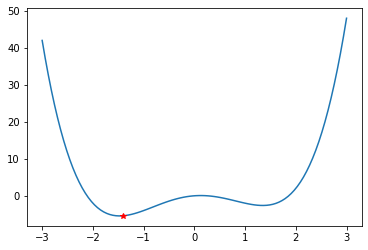

-1.4142135623730951


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.linalg as spla

def quartic_one_d(a,b,iterations=100):
    #Returns an approximate minimizer for a,b, as above.
    
    if a > 0:
        if b == 0:
            return np.sqrt(a)
        elif b>0:
            y0 = -np.sqrt(a)
        else:
            y0 = np.sqrt(a)
    else:
        y0 = 0
    
    
    
    step_strength = .1#*(np.abs(a) + np.abs(b))
    
    for i in range(iterations):
        #print(step_strength*(b + 2*y0*2*(y0**2-a)))
        #y0 -= step_strength*(b + 2*y0*2*(y0**2-a))
        gradient = 4*y0**3 - 4*a*y0 + b
        if np.abs(gradient) < step_strength:
            y0 -= step_strength*(4*y0**3 - 4*a*y0 + b)
        else:
            y0 -= step_strength*gradient/np.abs(gradient)
        #print(y0)
    
    return y0

def quartic_one_d_vectorized(a,b,iterations=100):
    y0 = np.zeros(a.shape)
    
    y0 = np.sqrt(np.abs(a))*(1.*(b <= 0) - 1.*(b >0))
    
    step_strength = .1#*(np.abs(a) + np.abs(b))
    
    for i in range(iterations):
        #print(step_strength*(b + 2*y0*2*(y0**2-a)))
        #y0 -= step_strength*(b + 2*y0*2*(y0**2-a))
        gradient = 4*y0**3 - 4*a*y0 + b
        
        y0 -= step_strength*gradient/(np.abs(gradient) + step_strength**2)

    
    return y0

def plot_quartic(a,b):
    y = np.linspace(-3,3,100)

    f = y**4 -2*a*y**2 + b*y

    plt.plot(y,f)


a = 2
b = 1

approx_min = quartic_one_d(a,b)
approx_val = approx_min**4 - 2*a*approx_min**2 + b*approx_min

y = np.linspace(-3,3,100)

f = y**4 -2*a*y**2 + b*y

plt.plot(y,f)
plt.plot(approx_min, approx_val, 'r*')
plt.show()

print(approx_min)

The marginal problem is given by
$$
J_x(y) = |y|^4-2y^T\psi(x)y-4\varphi(x)^T y+C(x)
$$
where
$$
\psi(x)=|x|^2-2\int yy^T\,d\pi^*(x,y) +\,\text{Id}\int |x|^2-|y|^2\,d\pi^*(x,y)
$$

$$
\varphi(x)=2\left(\int yx^T\,d\pi^*(x,y)\right)x+\int y(|y|^2-|x|^2)\,d\pi^*(x,y)
$$

In the one-dimensional case these all turn into scalars.

In [121]:
def find_moment_matrices_one_d(x,y):
    #Finds the moment matrices associated with the marginal problem given input points x
    #and current output points y.
    
    #x is assumed to by n x d and y is assumed to be 1xn.
    
    d = x.shape[1]
    norm_x_squared = spla.norm(x,axis=1)**2
    #print(norm_x_squared)
    norm_y_squared = y**2
    #print(norm_y_squared)
    
    psi = norm_x_squared - 2*np.mean(y**2) + np.mean(norm_x_squared -norm_y_squared)
    phi = -4*(2*np.mean(np.outer(y,np.ones(d))*x,axis=0)@x.T + np.mean(y*(norm_y_squared-norm_x_squared)))
    
   
    #print(psi)
    #print(phi)
    return [psi,phi]


def update_y(psi,phi,x,y):
    #returns new candidate values for y given current parameter values passed
    #from find_moment_matrices
    yout = np.zeros(y.shape)
    
    yout = quartic_one_d_vectorized(psi,phi,iterations=2000)
    
    #for i in range(len(y)):
    #    yout[i] = quartic_one_d(psi[i],phi[i],iterations=1000)
    return yout


def improve_sol(x,y):
    
    [psi,phi] = find_moment_matrices_one_d(x,y)
    return update_y(psi,phi,x,y)

from sklearn.datasets import load_digits
data=load_digits()
color=data.target[:]
x_data=data.data[:]
'''
k = 1000

x_data = np.zeros((2*k,2))
x_data[0:k,1] = .2
x_data[k:,1] = -.2

theta = np.linspace(0,2*np.pi, k//4)
circle_data = np.zeros((k//4,2))
circle_data[:,0] = np.cos(theta)
circle_data[:,1] = np.sin(theta)
x_data = np.vstack((x_data,circle_data))
'''

#y_init = np.random.uniform(-1,1,x_data.shape[0])
#y_init = y_init-np.mean(y_init)

y_init = 1.1*x_data@np.ones(64)
#y_init = x_data[:,1]

#print(y_init)

In [124]:
y = y_init
#[psi,phi] = find_moment_matrices_one_d(x_data,y)
#plot_quartic(psi[0],phi[0])
#print(psi[0],phi[0])


for i in range(100):
    y = improve_sol(x_data,y)
    y = y-np.mean(y)
    #print(y)

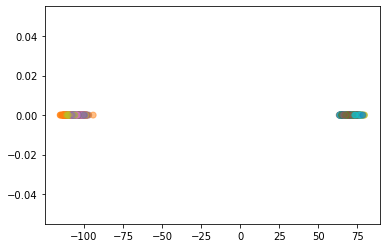

In [125]:
plt.scatter(y,np.zeros(1797), c=color,cmap='tab10', alpha=0.5)
plt.show()